# TODO

### Check other possible effects of opto

In [141]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import random
from datetime import datetime
from scipy import stats


warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

output_directory_name =  'D1andD2opto'

outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    print('I dont find this')
else:
    # Read the dataframe
    AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')
    print('Dataframe read')

Dataframe read


In [ ]:
# send data to Joaquin
# d1_animals_to_select = ['D1opto-03', 'D1opto-04', 'D1opto-05']
# d2_animals_to_select = ['D2opto-03', 'D2opto-04', 'D2opto-05']
opto_to_select = ['Right', 'Left']
columns_to_select = ['AnimalID', 'SessionID', 'TrialHighPerc', 'FirstPoke', 'OptoStim', 'Stimulation']

optodf = AnimalsDF[AnimalsDF.SessionID.isin(sess_list)].copy()
optodf = optodf[optodf.Stimulation.isin(opto_to_select)]
optodf = optodf[columns_to_select]
optodf['Cohort'] = np.nan
for animal in pd.unique(optodf.AnimalID):
    optodf.at[optodf.AnimalID == animal, 'Cohort'] = animal.split('-')[0]

optodf.rename(columns={"FirstPoke": "Side_selected", "TrialHighPerc": "Percentage_of_high_frequency",
                      "OptoStim": "Optostimulation", 'Stimulation': 'Optostimulation_side'})
optodf

In [ ]:
optodf.to_pickle(outputDir + 'for_Joaquin_glm_opto_unilateral_sessions_selected_dataframe.pkl')

#### Create a summary of the stimulation sessions for every mouse

In [3]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]
# pulledData = pulledData[pulledData.Protocol == 'Aud_Psycho']
# pulledData = pulledData[pulledData.AnimalID.isin(['D1opto-03', 'D2opto-04'])]

In [4]:
# Select only sessions older than a particular date
str_format = '%b%d %H:%M'
limit_date = 'Nov02 12:00'
session_times = [datetime.strptime(x, str_format) for x in pulledData.SessionTime.unique()]
date_mask = [x > datetime.strptime(limit_date, str_format) for x in session_times]
selected_dates = [x.strftime(str_format) for x in np.array(session_times)[date_mask]]

In [5]:
# Include the data of the first batch of animals here
first_batch_animals = ['D1opto-01', 'D1opto-02', 'D2opto-01', 'D2opto-02']
fba_st = pulledData[pulledData.AnimalID.isin(first_batch_animals)].SessionTime.unique()

selected_dates = selected_dates + list(fba_st)

pulledData = pulledData[pulledData.SessionTime.isin(selected_dates)]

In [6]:
# Include the new data and subselect
new_opto = pd.read_pickle(GeneralDirectory + 'D1andD2opto-learning_Dec21' + '_Analysis/' + 'D1andD2opto-learning_Dec21' + '_dataframe.pkl')
# Correct a session that was not properly marked
new_opto.loc[new_opto.SessionID=='D2opto-12 Dec14 13:55', 'Stimulation'] = 'Left'
new_opto = new_opto[new_opto.Stimulation != "NoStimulation"]
new_opto = new_opto[new_opto.Protocol == "Aud_Psycho"]

pulledData = pd.concat([pulledData, new_opto], ignore_index=True)

In [7]:
# get a list of each animalID in each condition
for EG in pd.unique(pulledData.ExperimentalGroup):
    print(str(EG) + ':')
    for AI in pd.unique(pulledData[pulledData.ExperimentalGroup == EG].AnimalID):
        print('  ' + AI)

optoinhibition:
  D1opto-01
  D1opto-02
  D1opto-03
  D1opto-05
  D1opto-06
  D1opto-08
  D2opto-01
  D2opto-02
  D2opto-03
  D2opto-04
  D2opto-05
  D2opto-07
  D1opto-10
  D1opto-11
  D1opto-12
  D1opto-13
  D2opto-08
  D2opto-09
  D2opto-10
  D2opto-11


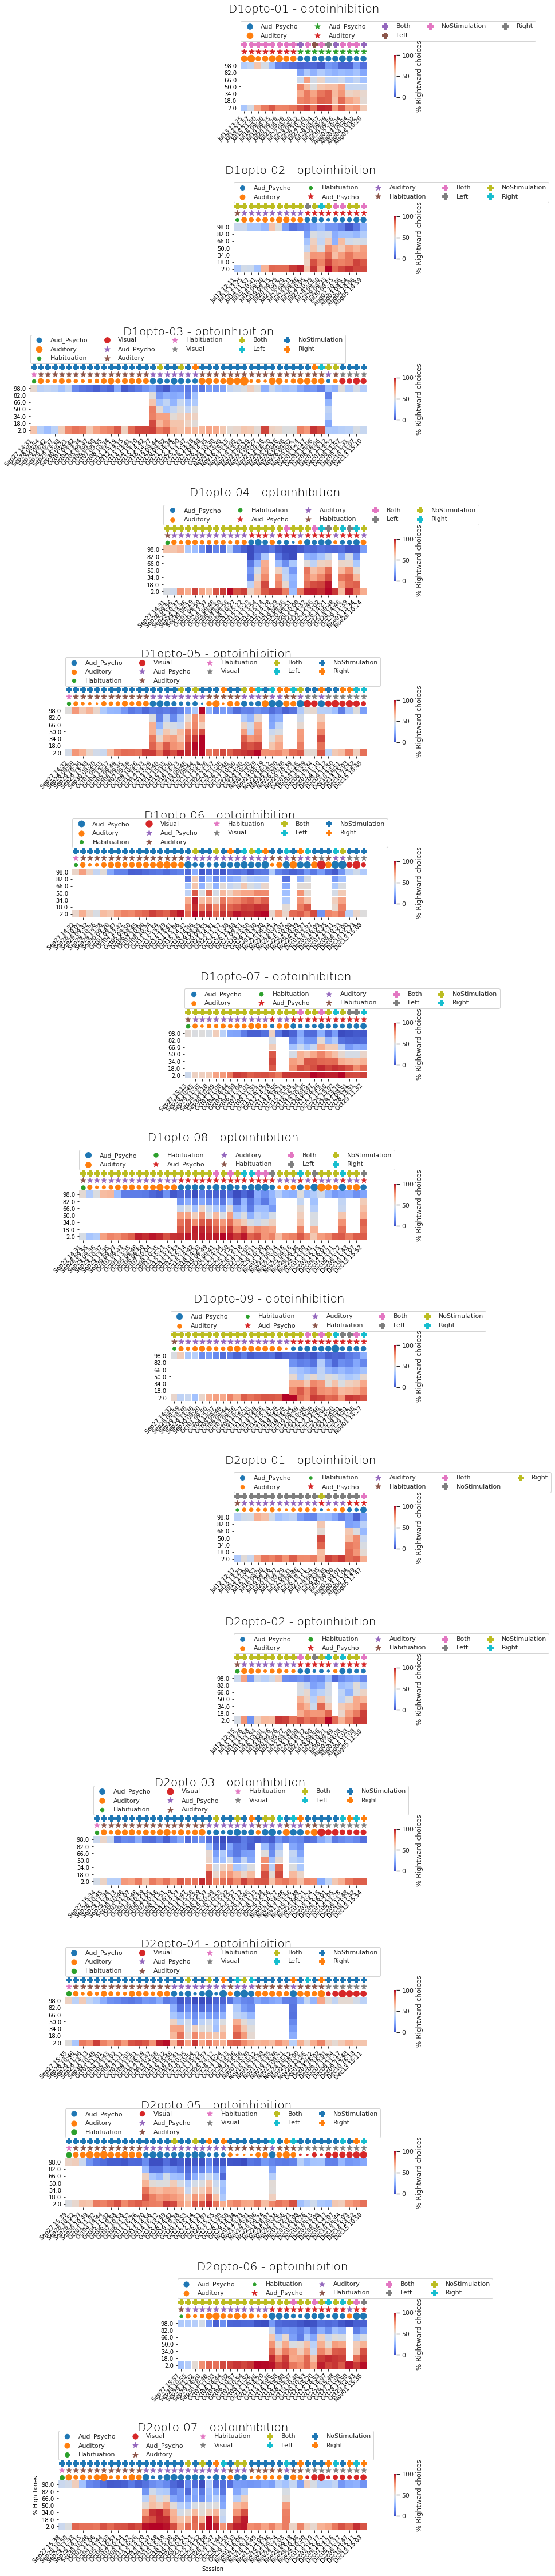

In [8]:
# plot a summary of all the animals in the dataset
fig, ax = plt.subplots(len(pd.unique(AnimalsDF.AnimalID)), 1, figsize=(17,5 * len(pd.unique(AnimalsDF.AnimalID))))
axs = ax.ravel()
fig.subplots_adjust(hspace=1.3)
for i, animal in enumerate(pd.unique(AnimalsDF.AnimalID)):
    aDF = AnimalsDF[AnimalsDF.AnimalID == animal]
    dfToPlot = plot_utils.summary_matrix(aDF)
    axs[i] = plot_utils.summary_plot(dfToPlot, aDF, axs[i], top_labels=['Protocol', 'Stimulation'])
    
plt.savefig(outputDir + 'psychometricPerformanceAllSessionsHeatmap.pdf',
            transparent=True,dpi = 500, bbox_inches='tight')
plt.show(fig)

### Custom fitting

##### Test a different way of calculating / visualizing differences. Generate 'fake opto datasets' and plot the distributions for every difficulty

In [11]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [12]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [13]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = pulledData[pulledData['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [14]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
    random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

##### populate the random dataframe with parameters about the sigmoid fits for every random occurrence

In [ ]:
# random_opto_df['sf_slopes'] = None
# random_opto_df['sf_intercepts'] = None
# random_opto_df['sf_upper-bounds'] = None
# random_opto_df['sf_lower-bounds'] = None

# for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
#     session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
#     avail_diffs = random_opto_df.loc[session_idx].Difficulties
#     rand_choices_ds = random_opto_df.loc[session_idx].Random_choices
    
#     slope_list = np.empty(len(rand_choices_ds))
#     inter_list = np.empty(len(rand_choices_ds))
#     upper_list = np.empty(len(rand_choices_ds))
#     lower_list = np.empty(len(rand_choices_ds))
#     updown_list = np.empty(len(rand_choices_ds))

#     for i in range(len(slope_list)):
#         s, b, u, l = cuf.fit_custom_sigmoid(difficulty=avail_diffs, performance=rand_choices_ds[i])
#         slope_list[i] = s
#         inter_list[i] = b
#         upper_list[i] = u
#         lower_list[i] = l

#     random_opto_df.at[session_idx, 'sf_slopes'] = slope_list
#     random_opto_df.at[session_idx, 'sf_intercepts'] = inter_list
#     random_opto_df.at[session_idx, 'sf_upper-bounds'] = upper_list
#     random_opto_df.at[session_idx, 'sf_lower-bounds'] = lower_list

#     update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

In [ ]:
# # intercept is the left-right shift of the curve
# # I need another metric for the up-down shift
# # Is the predicted value at the 50% the proper measure of this?

# # Calculate the area between the curves of the random fits and the opto ones,
# # as an alternative measure to the 50% value of the curve to measure the shift

# random_opto_df['sf_updown_shift'] = None
# x = np.linspace(0, 100)

# for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
#     session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
#     # get data for opto
#     opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
#     trialsDif = np.array(opto_df['TrialHighPerc'])
#     sideSelected = np.array(opto_df['FirstPoke'])
#     difficulty, performance = cuf.get_choices(sideSelected, trialsDif)
#     so, bo, uo, lo = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance) 
#     opto_yvals = cuf.sigmoid_func(x, *[so, bo, uo, lo])
    
#     # get data for the shuffles
#     slope_list = random_opto_df.loc[session_idx].sf_slopes
#     inter_list = random_opto_df.loc[session_idx].sf_intercepts
#     upper_list = random_opto_df.loc[session_idx, 'sf_upper-bounds']
#     lower_list = random_opto_df.loc[session_idx, 'sf_lower-bounds']
#     updown_list = np.empty(len(slope_list))

#     for i in range(len(slope_list)):
#         s, b, u, l = slope_list[i], inter_list[i], upper_list[i], lower_list[i]
#         y_vals = cuf.sigmoid_func(x, *[s, b, u, l])
#         # calculate area and normalize
#         updown_list[i] = np.sum(y_vals - opto_yvals) / len(x)
    
#     random_opto_df.at[session_idx, 'sf_updown_shift'] = updown_list
#     update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

In [ ]:
# # calculate, for each session, the std of the distributions of these shifts,
# # the lower and upper percentiles
# # the values of the real opto data,
# # as well as the mean, and it's difference with the opto trials
# random_opto_df['slopes_mean'] = None
# random_opto_df['slopes_std'] = None
# random_opto_df['slopes_low_per'] = None
# random_opto_df['slopes_high_per'] = None

# random_opto_df['shift_mean'] = None
# random_opto_df['shift_std'] = None
# random_opto_df['shift_low_per'] = None
# random_opto_df['shift_high_per'] = None

# random_opto_df['opto_slope'] = None
# random_opto_df['opto_shift'] = None

# # Get a column with the mouse name
# random_opto_df['AnimalID'] = None
# # And the stimulation side
# random_opto_df['Stimulation'] = None
# # And the type of mouse
# random_opto_df['Genotype'] = None

# for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
#     session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
#     slopes = random_opto_df.loc[session_idx].sf_slopes
#     shifts = random_opto_df.loc[session_idx].sf_updown_shift
    
#     opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
#     trialsDif = np.array(opto_df['TrialHighPerc'])
#     sideSelected = np.array(opto_df['FirstPoke'])
#     difficulty, performance = cuf.get_choices(sideSelected, trialsDif)
#     s, b, u, l = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance)
# #     ups = cuf.sigmoid_func(50, s, b, u, l)
#     ups = 0
    
#     random_opto_df.at[session_idx, 'slopes_mean'] = np.mean(slopes)
#     random_opto_df.at[session_idx, 'slopes_std'] = np.std(slopes)
#     random_opto_df.at[session_idx, 'slopes_low_per'] = np.percentile(slopes, 5)
#     random_opto_df.at[session_idx, 'slopes_high_per'] = np.percentile(slopes, 95)
    
#     random_opto_df.at[session_idx, 'shift_mean'] = np.mean(shifts)
#     random_opto_df.at[session_idx, 'shift_std'] = np.std(shifts)
#     random_opto_df.at[session_idx, 'shift_low_per'] = np.percentile(shifts, 5)
#     random_opto_df.at[session_idx, 'shift_high_per'] = np.percentile(shifts, 95)
    
#     random_opto_df.at[session_idx, 'opto_slope'] = s
#     random_opto_df.at[session_idx, 'opto_shift'] = ups
    
#     mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
#     random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
#     random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]
#     random_opto_df.at[session_idx, 'Stimulation'] = opto_df.iloc[0]['Stimulation']

#     update_progress((sc + 1) / len(pd.unique(pulledData['SessionID'])))

In [15]:
# save this dataframe as it takes very long to calculate
random_opto_df.to_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [8]:
# read it
random_opto_df = pd.read_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [9]:
# select only auditory trials (remove visual)
non_visual_sessions = list(pulledData[pulledData.Protocol != 'Visual'].SessionID.unique())
pulledData = pulledData[pulledData.SessionID.isin(non_visual_sessions)]
random_opto_df = random_opto_df[random_opto_df.SessionID.isin(non_visual_sessions)]

Progress: [####################] 100.0%


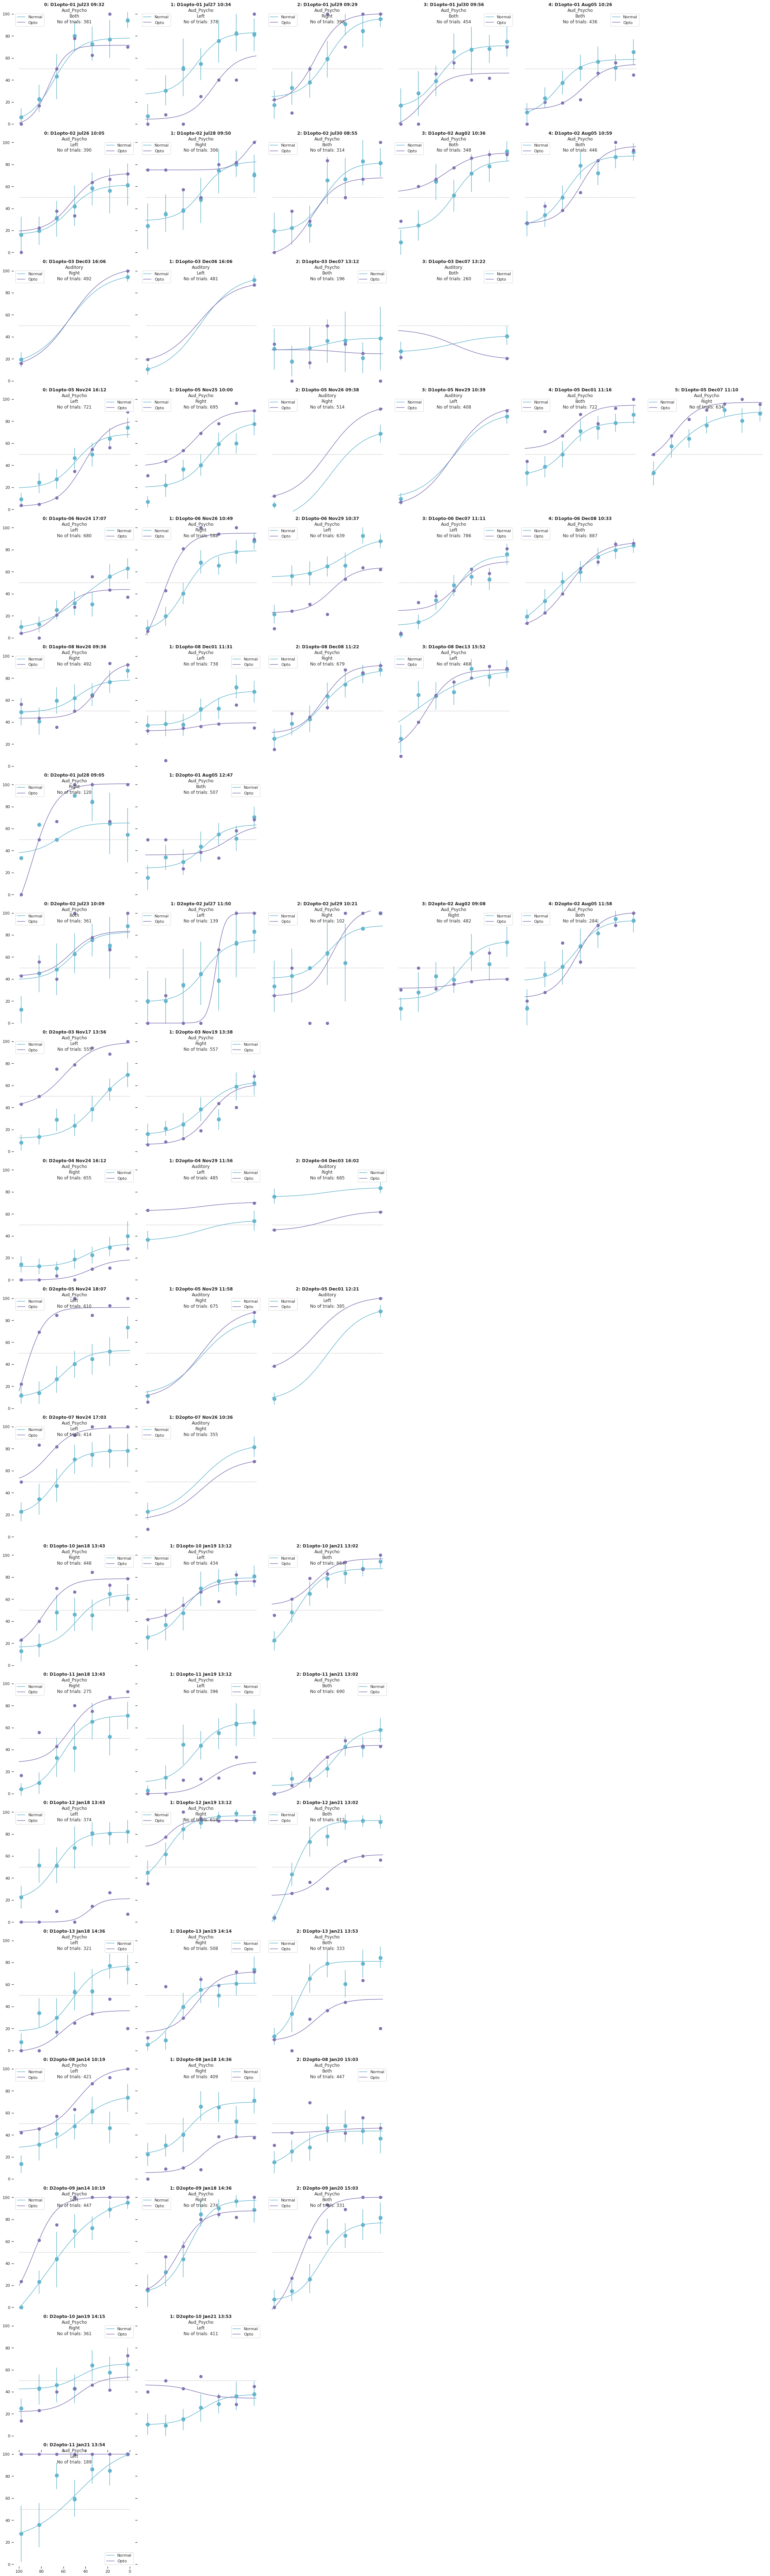

In [18]:
# Plot the data with the error bars for the random sampling, and the custom fitting

CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
        # overlay fits
        for i, condition in enumerate(CondList):
            plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
                                       color=ColorList[i], label=LabelList[i], plot_points=False)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

#### Visual effects

In [8]:
# plot data for visual (don't run if the two cells above are run)
visual_sessions = list(pulledData[pulledData.Protocol == 'Visual'].SessionID.unique())
pulledDataVisual = pulledData[pulledData.SessionID.isin(visual_sessions)]
random_opto_df_visual = random_opto_df[random_opto_df.SessionID.isin(visual_sessions)]

Progress: [####################] 100.0%


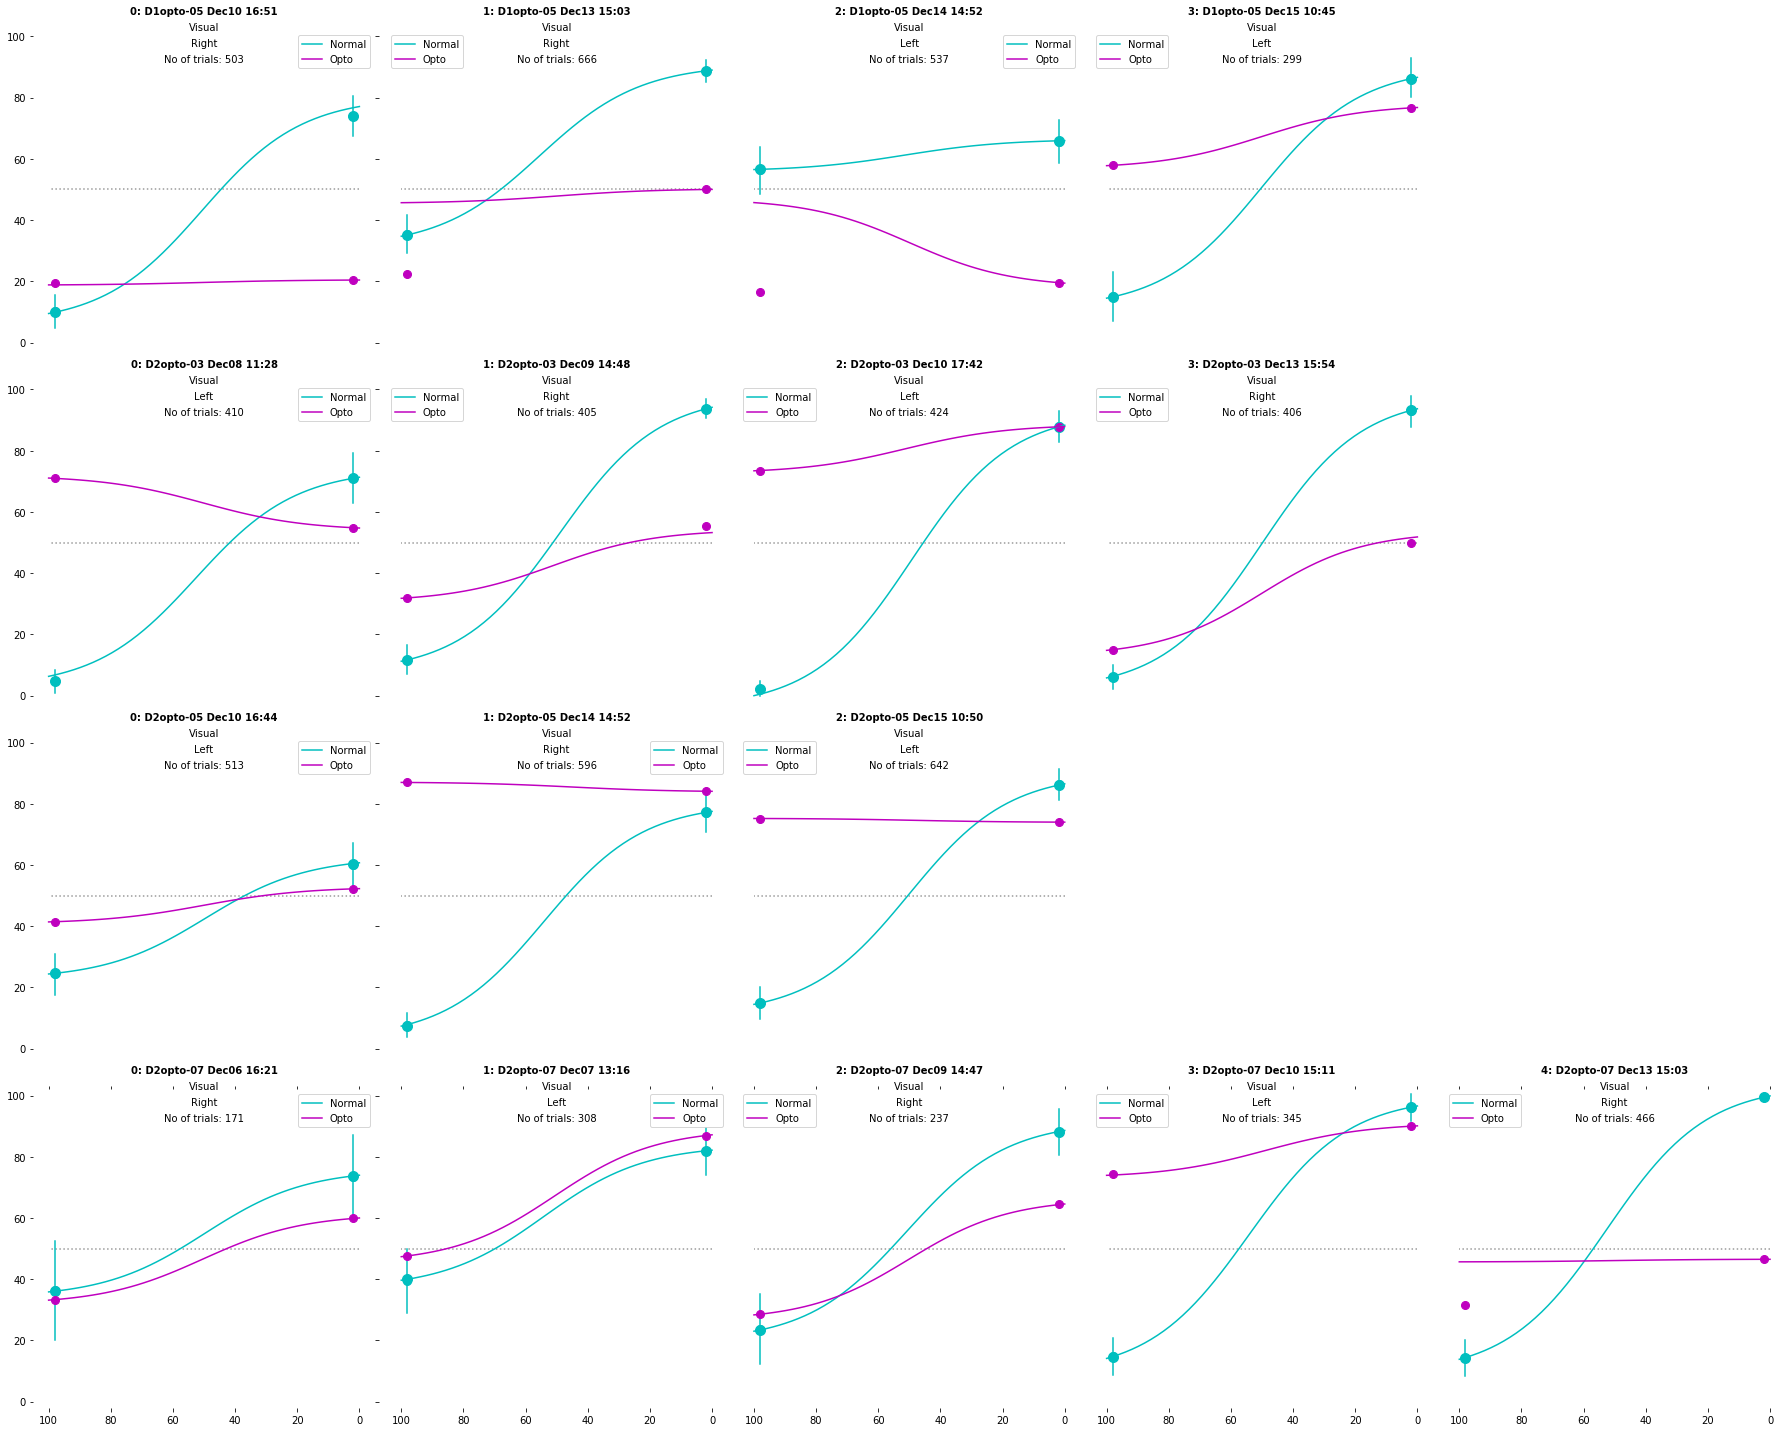

In [9]:
# Plot the data with the error bars for the random sampling, and the custom fitting

CondList = [(pulledDataVisual['OptoStim']==0),
            (pulledDataVisual['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledDataVisual.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledDataVisual['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledDataVisual['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledDataVisual['AnimalID'])):
    animal_df = pulledDataVisual[pulledDataVisual['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledDataVisual[pulledDataVisual['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df_visual[random_opto_df_visual.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df_visual[random_opto_df_visual.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
        # overlay fits
        for i, condition in enumerate(CondList):
            plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
                                       color=ColorList[i], label=LabelList[i], plot_points=False)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledDataVisual['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_visual.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

### Example curve

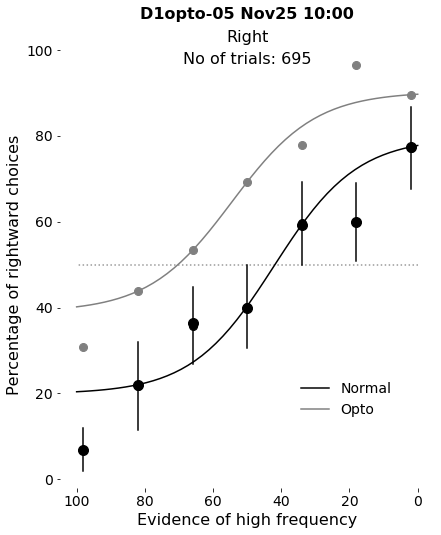

In [10]:
# Plot a nice example
animal = 'D1opto-05'
session = 'D1opto-05 Nov25 10:00'

CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['black', 'grey']
LabelList = ['Normal', 'Opto']

fig, ax = plt.subplots(1, 1,
                        figsize=(7, 7),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

# ax.axis('off')

animal_df = pulledData[pulledData['AnimalID'] == animal]
session_df = pulledData[pulledData['SessionID'] == session]
        
ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()

plot_utils.plot_random_optolike_choices(df=session_df,
                                        ax=ax,
                                        colorlist=ColorList,
                                        fake_dataset_m_and_std=[avail_diffs,
                                                                np.mean(rand_choices_ds, axis=0),
                                                                np.std(rand_choices_ds, axis=0)])
# overlay fits
for i, condition in enumerate(CondList):
    plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
                               color=ColorList[i], label=LabelList[i], plot_points=False)
#axs[counter].set_ylabel('')
#axs[counter].set_xlabel('')
# ax.axis('on')
# remove some ticks
# ax.tick_params(top=False, bottom='on', left='on', right=False)

ax.set_ylabel('Percentage of rightward choices' , fontsize=16)
    
ax.set_xlabel('Evidence of high frequency', fontsize=16)


ax.set_ylim(-2., 102.)
ax.legend(bbox_to_anchor=(.9, .25), loc=0, borderaxespad=0., ncol=1, frameon=False, fontsize=14)
# ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
#                labelleft='on', labelbottom='on')
# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()

ax.invert_xaxis()

#         ax.get_legend().remove()
ax.text(.5,1.05, str(session), \
                  horizontalalignment='center', fontweight='bold', transform=ax.transAxes, fontsize=16)

# ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
#                   horizontalalignment='center', transform=ax.transAxes)
ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                  horizontalalignment='center', transform=ax.transAxes, fontsize=16)
ax.text(.5,.95, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                  horizontalalignment='center', transform=ax.transAxes, fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Progress: [####################] 100.0%


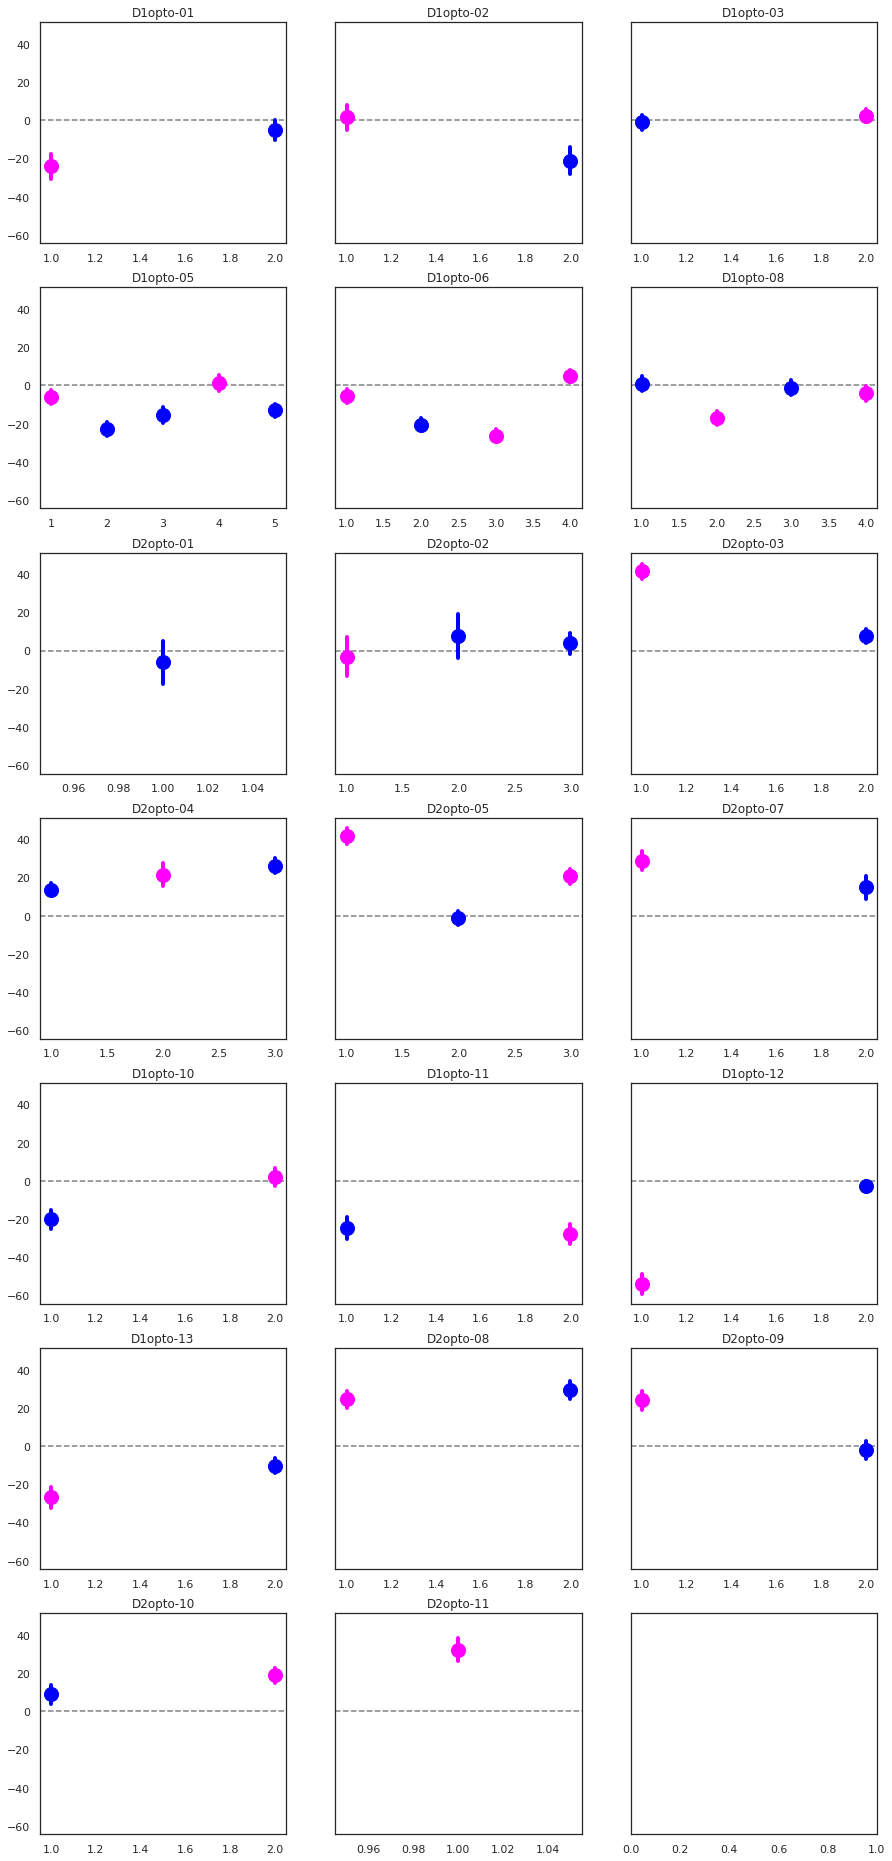

In [20]:
# plot only the shift for unilateral stimulations, adding the percentiles

stim_types = ['Right', 'Left']
colors = ['blue', 'magenta']

fig, axs = plt.subplots(math.ceil(len(pd.unique(random_opto_df.AnimalID))/3), 3,
                        figsize=(15, 5 * len(pd.unique(random_opto_df.AnimalID))/3),
                        facecolor='w', edgecolor='k', sharex=False, sharey=True)
axs = axs.ravel()

for ac, animal in enumerate(pd.unique(random_opto_df.AnimalID)):
    ax = axs[ac]
#     ax.axvline(0, color='grey', linestyle='--')
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(animal)
    
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    sc = 0￼
# def plot_hist_and_line(data_for_hist, line, ax):
#     ax.hist(data_for_hist, bins=100, color='c')
#     ax.axvline(x=line, color='m')
#     return ax
In [ ]:
￼
# # Plot the distributions
​
# n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()
​
# fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
#                         figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
#                         facecolor='w', edgecolor='k')
​
# fig.subplots_adjust(hspace = .2, wspace=1)
​
# for ax in axs.ravel(): ax.axis('off')
​
# for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
#     animal_df = pulledData[pulledData['AnimalID'] == animal]
    
#     for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
#         session_df = pulledData[pulledData['SessionID'] == session]
        
#         ax = axs[an_counter, counter]        
​
#         session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
# #         opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
# #         trialsDif = np.array(opto_df['TrialHighPerc'])
# #         sideSelected = np.array(opto_df['FirstPoke'])
# #         difficulty, performance = cuf.get_choices(sideSelected, trialsDif)
​
# #         s, b, u, l = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance)
# #         ups = cuf.sigmoid_func(50, s, b, u, l)
#         ups = 0
#         plot_hist_and_line(random_opto_df.loc[session_idx].sf_updown_shift, ups, ax=ax)
        
#         #axs[counter].set_ylabel('')
#         #axs[counter].set_xlabel('')
#         ax.axis('on')
#         # remove some ticks
#         ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
#                        labelleft='on', labelbottom='on')
#         if not ax.is_first_col():
#             ax.set_ylabel('')
#             ax.set_yticks([])
#         if not ax.is_last_row():
#             ax.set_xlabel('')
#             ax.set_xticks([])
                   
# #         ax.set_ylim(-2., 102.)
#         #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
#         ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
#                        labelleft='on', labelbottom='on')
        
        
#         # calculate pval
#         pval = np.sum(random_opto_df.loc[session_idx].sf_updown_shift > ups) / len(random_opto_df.loc[session_idx].sf_updown_shift)
#         if pval > .5: pval = 1 - pval
        
        
#         # get rid of the frame if not significant
#         if pval > .05:
#             for spine in ax.spines.values():
#                 spine.set_visible(False)
        
#         plt.tight_layout()
        
#         ax.invert_xaxis()
        
# #         ax.get_legend().remove()
#         ax.text(.5,1.05, str(counter) + ': ' + (session), \
#                           horizontalalignment='center', fontweight='bold', transform=ax.transAxes)
​
#         ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
#                           horizontalalignment='center', transform=ax.transAxes)
#         ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
#                           horizontalalignment='center', transform=ax.transAxes)
#         ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
#                           horizontalalignment='center', transform=ax.transAxes)
#         ax.text(.5,.85, 'pval = ' + "{:.3f}".format(pval), horizontalalignment='center', transform=ax.transAxes)
​
​
#     update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
# update_progress(1)
# plt.savefig(outputDir + output_directory_name + '_significance_shifts.pdf', transparent=True, bbox_inches='tight')
​
# plt.show(fig)
Group sessions together
In [ ]:

    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        if st_t in stim_types:
            sc = sc + 1
#             o_s = animal_rdf.loc[session_idx].opto_shift
#             sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
#             sh_std = animal_rdf.loc[session_idx].shift_std
#             sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
#             sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s
            st_idx = stim_types.index(st_t)

            sh_d = animal_rdf.loc[session_idx].contralateral_bias
            sh_std = animal_rdf.loc[session_idx].bias_std

            ax.plot(sc, sh_d, 'o', ms=14,color=colors[st_idx])
            ax.plot([sc, sc], [sh_d-sh_std, sh_d+sh_std], color=colors[st_idx], linewidth=4)
#             ax.plot([sc, sc], [sh_lper, sh_hper], color=colors[st_idx], linewidth=2)

    update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_significance_shift_grouped-per-animal.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [11]:
# select only psychometric version
psych_sessions = list(pulledData[pulledData.Protocol == 'Aud_Psycho'].SessionID.unique())
pulledData = pulledData[pulledData.SessionID.isin(psych_sessions)]
random_opto_df = random_opto_df[random_opto_df.SessionID.isin(psych_sessions)]

In [12]:
# Define the minimum required number of trials per session
MIN_TRIALS = 150

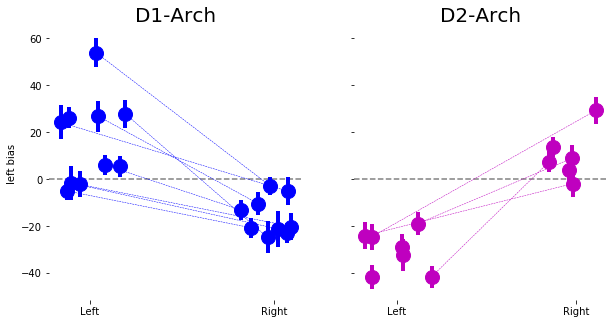

In [13]:
# Remove the JAWS mice
mice_to_remove = ['D1opto-08', 'D1opto-09']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
# Take the first two distinct tests in each direction for the grouping, and plot first left and then right
# add jitter and connect the sessions for the same mouse
jitter = 0.2
alpha = 1

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto']
labels_for_title = ['D1-Arch', 'D2-Arch']
colors = ['b', 'm']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (5 * len(mice_cohorts), 5), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(labels_for_title[i], fontsize=20)
#     ax.tick_params(which='both', top='off', bottom='off', left='on', right='off',
#                        labelleft='on', labelbottom='on')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(stim_types)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)
    
axs[0].set_ylabel('left bias')


for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # create an array to store connecting dots
    animal_ys = np.zeros(len(stim_types))
    animal_xs = np.zeros(len(stim_types))
    animal_flag = np.zeros(len(stim_types))
    for session in pd.unique(animal_rdf.SessionID):
        # if there are enough number of trials:
        if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
            session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
            cohort = animal_rdf.loc[session_idx].Genotype
            st_t = animal_rdf.loc[session_idx].stimulated_side
            ax = axs[mice_cohorts.index(cohort)]
            if st_t in stim_types:
                st_t_idx = stim_types.index(st_t)

#                     o_s = animal_rdf.loc[session_idx].opto_shift
#                     sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
#                     sh_std = animal_rdf.loc[session_idx].shift_std
                sh_d = animal_rdf.loc[session_idx].bias_mean
                sh_std = animal_rdf.loc[session_idx].bias_std

#                     sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
#                     sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                imp_jit = random.uniform(-jitter, jitter)
                x_pos = st_t_idx + imp_jit
                animal_xs[st_t_idx] = x_pos
                animal_ys[st_t_idx] = sh_d
                animal_flag[st_t_idx] = 1

                #means
                ax.plot(x_pos, sh_d, 'o', ms=14,color=colors[mice_cohorts.index(cohort)], alpha=alpha)
                #stds
                ax.plot([x_pos, x_pos], [sh_d-sh_std, sh_d+sh_std], color=colors[mice_cohorts.index(cohort)], linewidth=4, alpha=alpha)
                #percentiles
#                     ax.plot([x_pos, x_pos], [sh_lper, sh_hper], color=colors[st_t_idx], linewidth=2, alpha=alpha)
            
    #connect
    if np.all(animal_flag == 1):
        ax.plot(animal_xs, animal_ys, color = colors[mice_cohorts.index(cohort)], linewidth = 0.5, linestyle = '--')

    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped-with-bars_per-side.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

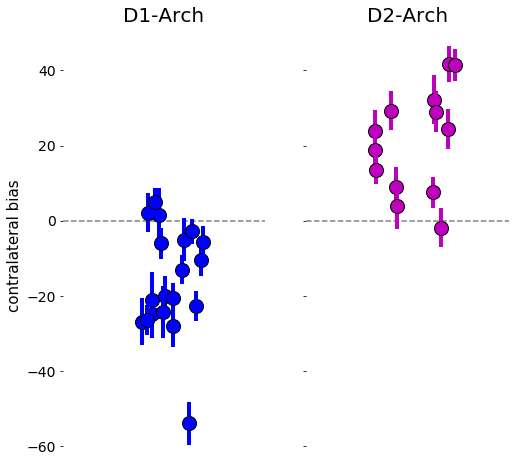

In [14]:
# Plot the contralateral shift

animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
# Take the first two distinct tests in each direction for the grouping, and plot first left and then right
# add jitter and connect the sessions for the same mouse
jitter = 0.4
alpha = 1

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['b', 'm']
labels_for_legend = ['D1-Arch', 'D2-Arch']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (4 * len(mice_cohorts), 8), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(labels_for_legend[i], fontsize=20)
#     ax.tick_params(which='both', top='off', bottom='off', left='on', right='off',
#                        labelleft='on', labelbottom='on')
    ax.set_xticks([])
    ax.set_xlim([-jitter*2, jitter*2])
#     ax.set_xticklabels(stim_types)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
axs[0].set_ylabel('contralateral bias', fontsize=15)


for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
#     stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.zeros(len(stim_types))
    animal_xs = np.zeros(len(stim_types))
    animal_flag = np.zeros(len(stim_types))
    for session in pd.unique(animal_rdf.SessionID):
        # if there are enough number of trials:
        if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
            session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
            cohort = animal_rdf.loc[session_idx].Genotype
            st_t = animal_rdf.loc[session_idx].stimulated_side
            ax = axs[mice_cohorts.index(cohort)]
            if st_t in stim_types:
#                 st_t_idx = stim_types.index(st_t)
                st_t_idx = 0
#                 if stim_flags[st_t_idx] == 0:
#                     stim_flags[st_t_idx] = 1
#                     o_s = animal_rdf.loc[session_idx].opto_shift
#                     sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
#                     sh_std = animal_rdf.loc[session_idx].shift_std
                sh_d = animal_rdf.loc[session_idx].contralateral_bias
                sh_std = animal_rdf.loc[session_idx].bias_std

#                     sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
#                     sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                imp_jit = random.uniform(-jitter, jitter)
                x_pos = st_t_idx + imp_jit
                animal_xs[st_t_idx] = x_pos
                animal_ys[st_t_idx] = sh_d
#                 animal_flag[st_t_idx] = 1

                
                #stds
                ax.plot([x_pos, x_pos], [sh_d-sh_std, sh_d+sh_std], color=colors[mice_cohorts.index(cohort)], linewidth=4, alpha=alpha)
                #means
                ax.plot(x_pos, sh_d, 'o', ms=14, color='k', markerfacecolor=colors[mice_cohorts.index(cohort)], alpha=alpha,)
                #percentiles
#                     ax.plot([x_pos, x_pos], [sh_lper, sh_hper], color=colors[st_t_idx], linewidth=2, alpha=alpha)
            
    #connect
#     if np.all(animal_flag == 1):
#         ax.plot(animal_xs, animal_ys, color = 'grey', linewidth = 0.5, linestyle = '--')

    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped-with-bars_contralateral.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [58]:
# Remove duplicates by selecting the session with the best performance
stim_types = ['Left', 'Right']
sessions_to_remove = []

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # initialize lists
    st_list = []
    perf_list = []
    idx_list = []
    session_list = []
    for session in pd.unique(animal_rdf.SessionID):
        session_list.append(session)
        # find index
        session_idx = random_opto_df[random_opto_df.SessionID==session].index.item()
        idx_list.append(session_idx)
        # find performance
        perf_list.append(np.mean(pulledData[(pulledData['SessionID'] == session)]).CurrentPastPerformance20)
        # find type
        st_list.append(animal_rdf.loc[session_idx].stimulated_side)
        
    print('{}'.format(animal))
    for i in range(len(st_list)):
        print('\t{} performance of {} stim in {}, with index {}'.format(session_list[i],
                                                                         perf_list[i],
                                                                         st_list[i],
                                                                         idx_list[i]))

    for side in stim_types:
        b_list = [x==side for x in st_list]
        nsess = np.sum(b_list)
        print('\t\t{} has {} sessions'.format(side, nsess))
        if nsess > 1:
            sess_locs = list(np.where(b_list)[0])
            maxperfidx = np.argmax([perf_list[x] for x in sess_locs])
            idxtokeep = idx_list[sess_locs[maxperfidx]]
            print('\t\t\t{} max performance is idx {}'.format(side, idxtokeep))
            
            # add the rest to the list
            for i, sl in enumerate(sess_locs):
                if i != maxperfidx:
                    print('\t\t\t\tRemoving {}'.format(session_list[sl]))
                    sessions_to_remove.append(session_list[sl])

D2opto-11
	D2opto-11 Jan21 13:54 performance of 66.88235294117646 stim in Left, with index 82
		Left has 1 sessions
		Right has 0 sessions
D2opto-09
	D2opto-09 Jan14 10:19 performance of 76.76401869158879 stim in Left, with index 77
	D2opto-09 Jan18 14:36 performance of 77.84313725490196 stim in Right, with index 78
	D2opto-09 Jan20 15:03 performance of 75.99358974358974 stim in Both, with index 79
		Left has 1 sessions
		Right has 1 sessions
D1opto-13
	D1opto-13 Jan18 14:36 performance of 69.25496688741723 stim in Left, with index 71
	D1opto-13 Jan19 14:14 performance of 67.84253578732107 stim in Right, with index 72
	D1opto-13 Jan21 13:53 performance of 61.8312101910828 stim in Both, with index 73
		Left has 1 sessions
		Right has 1 sessions
D2opto-05
	D2opto-05 Nov24 18:07 performance of 65.76988155668359 stim in Left, with index 49
		Left has 1 sessions
		Right has 0 sessions
D2opto-03
	D2opto-03 Nov17 13:56 performance of 64.46828358208955 stim in Left, with index 40
	D2opto-03 No

In [60]:
sessions_to_remove

['D1opto-05 Dec07 11:10',
 'D1opto-06 Nov24 17:07',
 'D1opto-06 Nov29 10:37',
 'D2opto-02 Aug02 09:08']

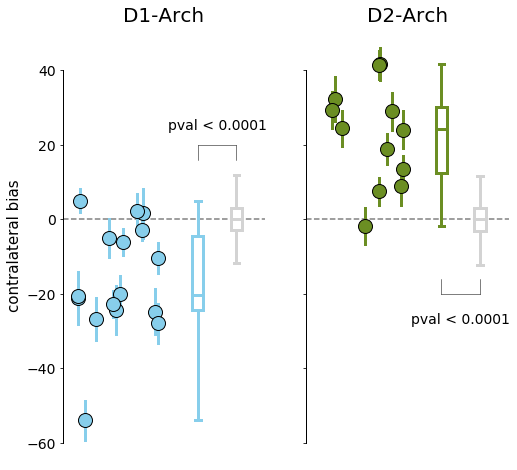

In [188]:
# Pretty version

animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
jitter = 0.3
alpha = 1
spread = jitter * 1.6
stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['skyblue', 'olivedrab']
labels_for_legend = ['D1-Arch', 'D2-Arch']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (4 * len(mice_cohorts), 8), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(labels_for_legend[i], fontsize=20)
    ax.set_xticks([])
    ax.set_xlim([-jitter*1.2, jitter*3])
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
    xmin, _ = axs[0].get_xaxis().get_view_interval()
    ax.plot((xmin, xmin), (-60, 40), color='black', linewidth=1) 

axs[0].set_ylabel('contralateral bias', fontsize=15)

jit_list = []

#stds
for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    for session in pd.unique(animal_rdf.SessionID):
        if session not in sessions_to_remove:
            # if there are enough number of trials:
            if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
                session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
                cohort = animal_rdf.loc[session_idx].Genotype
                st_t = animal_rdf.loc[session_idx].stimulated_side
                ax = axs[mice_cohorts.index(cohort)]
                if st_t in stim_types:
                    st_t_idx = 0
                    sh_d = animal_rdf.loc[session_idx].contralateral_bias
                    sh_std = animal_rdf.loc[session_idx].bias_std
                    imp_jit = random.uniform(-jitter, jitter)
                    x_pos = st_t_idx + imp_jit
                    jit_list.append(x_pos)

                    #stds
                    ax.plot([x_pos, x_pos], [sh_d-sh_std, sh_d+sh_std],
                            color=colors[mice_cohorts.index(cohort)], linewidth=3, alpha=alpha)

counter = 0
# means on top
mean_vals = [[], []]
sessions_used = [[], []]
for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    for session in pd.unique(animal_rdf.SessionID):
        if session not in sessions_to_remove:
            # if there are enough number of trials:
            if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
                session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
                cohort = animal_rdf.loc[session_idx].Genotype
                st_t = animal_rdf.loc[session_idx].stimulated_side
                ax = axs[mice_cohorts.index(cohort)]
                if st_t in stim_types:
                    st_t_idx = 0
                    sh_d = animal_rdf.loc[session_idx].contralateral_bias
                    imp_jit = random.uniform(-jitter, jitter)
                    x_pos = jit_list[counter]
                    counter+=1

                    #means
                    ax.plot(x_pos, sh_d, 'o', ms=14, color='k',
                            markerfacecolor=colors[mice_cohorts.index(cohort)])
                    #append to list
                    mean_vals[mice_cohorts.index(cohort)].append(sh_d)
                    sessions_used[mice_cohorts.index(cohort)].append(session)

# plot mean of means next to it, and random distribution, and pvalue
pvals = []
for i, ax in enumerate(axs):
    xm = np.mean(mean_vals[i])
    xstd = np.std(mean_vals[i])
#     ax.plot([spread, spread], [xm - xstd, xm + xstd], '-', color=colors[i],
#             zorder=50, linewidth=4, alpha=1)
#     ax.plot(spread, xm, '*', markerfacecolor=colors[i], zorder=50,
#             markeredgewidth=1, markersize=25, markeredgecolor='k')
    bp = ax.boxplot(mean_vals[i], positions=[spread], widths=0.07, 
                 patch_artist=True, showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=colors[i], linewidth=3)
    for patch in bp['boxes']:
        patch.set(facecolor='white')
    # random expectation. Mean at 0 by definition. Use the bias_std to sample from
    # do one instance only
    random_means = []
    for session in sessions_used[i]:
        # get x number of a random bias
        sess_std = random_opto_df[random_opto_df.SessionID==session].bias_std.values
        random_means.append(np.random.normal(loc=0.0, scale=sess_std[0], size=100))
    

    random_means_flat_list = [item for sublist in random_means for item in sublist]
    xm = np.mean(random_means_flat_list)
    xstd = np.std(random_means_flat_list)
    spr_adj = 1.5
#     ax.plot([spread*spr_adj, spread*spr_adj], [xm - xstd, xm + xstd], '-', color='lightgray',
#             zorder=50, linewidth=4, alpha=1)
#     ax.plot(spread*spr_adj, xm, '*', markerfacecolor='lightgray', zorder=50,
#             markeredgewidth=1, markersize=25, markeredgecolor='k')

    bp = ax.boxplot(random_means_flat_list, positions=[spread*spr_adj], widths=0.07, 
                 patch_artist=True, showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='lightgray', linewidth=3)
    for patch in bp['boxes']:
        patch.set(facecolor='white')
#     parts = ax.violinplot(random_means_flat_list, positions=[spread*spr_adj], showmeans=False,
#                           showmedians=False, showextrema=False)
#     for pc in parts['bodies']:
#         pc.set_alpha(1)
#         pc.set_zorder(-2)
#         pc.set_facecolor('whitesmoke')
#         pc.set_edgecolor('lightgrey')
#         # do only half
#         # get the center
#         m = np.mean(pc.get_paths()[0].vertices[:, 0])
#         # modify the paths to not go further left than the center
#         pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)


    pvals.append(stats.kruskal(mean_vals[i], random_means_flat_list).pvalue)

# add pvalues info
hlocs = [20, -20]
hadj = [1.2, 1.4]

for i, ax in enumerate(axs):
    pvaltext = 'something wrong'
    if pvals[i] < 0.0001:
        pvaltext = '< 0.0001'
    ax.text(x=spread*(1 + spr_adj)/2, y=hlocs[i]*hadj[i], s='pval {}'.format(str(pvaltext)),
            horizontalalignment='center', fontsize=14)
    ax.plot([spread, spread*spr_adj], [hlocs[i], hlocs[i]], color='k', linewidth=.5)
    ax.plot([spread, spread], [hlocs[i], hlocs[i]*.8], color='k', linewidth=.5)
    ax.plot([spread*spr_adj, spread*spr_adj], [hlocs[i], hlocs[i]*.8], color='k', linewidth=.5)
    ax.set_xticks([])
                
plt.savefig(outputDir + output_directory_name + '_shift_grouped-with-bars_contralateral_pretty.pdf',
            transparent=True, bbox_inches='tight')

plt.show(fig)

In [160]:
pvals

[5.700406068507114e-06, 1.9034278916030472e-07]

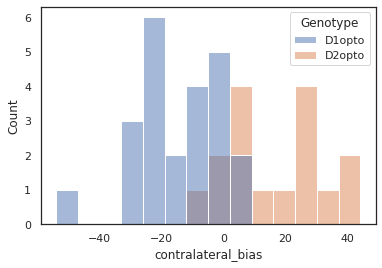

In [48]:
sns.histplot(data=random_opto_df, x='contralateral_bias', hue='Genotype', binwidth=7)

### Plot all together in a psychometric version

In [206]:
random_opto_df

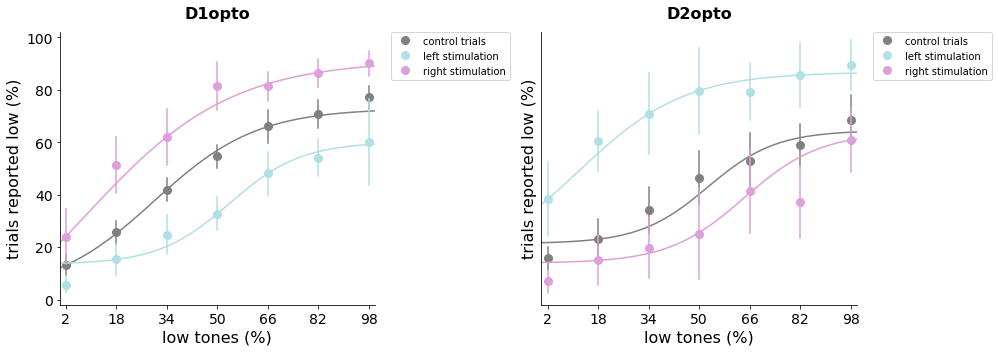

In [282]:
# Plot the data with the error bars for the random sampling, and the custom fitting

CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['powderblue', 'plum']
normal_color = 'gray'
LabelList = ['left stimulation', 'right stimulation']
Genotypes = ['D1opto', 'D2opto']
StimSides = ['Left', 'Right']

n_cols = 2

fig, axs = plt.subplots(1, n_cols,
                        figsize=(7 * n_cols, 5),
                        facecolor='w', edgecolor='k')

# fig.subplots_adjust(hspace = .2, wspace=4)

axs = axs.ravel()

for i, ax in enumerate(axs):

    genot = Genotypes[i]

    # select sessions
    a_mask = random_opto_df.AnimalID.isin(animals_list)
    g_mask = random_opto_df.Genotype == genot
    s_mask = random_opto_df.stimulated_side.isin(StimSides)

    sessions_list = random_opto_df[np.logical_and(np.logical_and(g_mask, a_mask), s_mask)].SessionID
    sessions_list_cleaned = list(set(sessions_list) - set(sessions_to_remove))
    
    # plot the normal choices and fit
    session_df = pulledData[pulledData['SessionID'].isin(sessions_list_cleaned)]
    df_for_plot = session_df[session_df.OptoStim==0]
    plot_utils.plot_regression(df=df_for_plot, ax=ax,
                               color=normal_color, label='', plot_points=False)
    
    predictDif, PsyPer, _, _, EB = \
    cuf.PP_ProcessExperiment(df_for_plot, 0, error_bars='SessionTime')
    plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                                    predictDif = predictDif, ax = ax, fakePred = None,
                                    realPred = None, color = normal_color, label = 'control trials', errorBars = EB)
    
    
    # plot each side
    for k, stside in enumerate(StimSides):
        s_mask = random_opto_df.stimulated_side == stside
        sessions_list = random_opto_df[np.logical_and(np.logical_and(g_mask, a_mask), s_mask)].SessionID
        sessions_list_cleaned = list(set(sessions_list) - set(sessions_to_remove))

        # plot the normal choices and fit
        session_df = pulledData[pulledData['SessionID'].isin(sessions_list_cleaned)]
        df_for_plot = session_df[session_df.OptoStim==1]
        plot_utils.plot_regression(df=df_for_plot, ax=ax,
                                   color=ColorList[k], label='', plot_points=False)

        predictDif, PsyPer, _, _, EB = \
        cuf.PP_ProcessExperiment(df_for_plot, 0, error_bars='SessionTime')
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                                        predictDif = predictDif, ax = ax, fakePred = None,
                                        realPred = None, color = ColorList[k], label = LabelList[k],
                                        errorBars = EB)

    ax.text(.5,1.05, genot, \
            horizontalalignment='center', fontweight='bold', transform=ax.transAxes, fontsize=16)    
    
    ax.axis('on')
    # remove some ticks
    ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                   labelleft='on', labelbottom='on')
    if not ax.is_first_col():
        ax.set_ylabel('')
        ax.set_yticks([])
    if not ax.is_last_row():
        ax.set_xlabel('')
        ax.set_xticks([])

    ax.set_ylim(-2., 102.)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)

    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # tick text size
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
    # reverse x axis ticks
    ax.set_xticklabels([2, 18, 34, 50, 66, 82, 98][::-1])


    ax.set_ylabel('trials reported low (%)' , fontsize=16)
    
    ax.set_xlabel('low tones (%)', fontsize=16)

plt.tight_layout()

plt.savefig(outputDir + output_directory_name + 'psychometric_grouped.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

### Plot a simpler combined version

In [189]:
# Calculate the contralateral bias for each contralateral evidence trial

random_opto_df['contralateral_evidence'] = None
random_opto_df['contralateral_bias_trials'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = random_opto_df.loc[session_idx, 'stimulated_side']

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    
    # for the sensory evidence: 2.0 is majority of low tones,
    # which means low sensory contralateral evidence for trials on the right.
    # Do the same as above, reversing the difficulties on left
    
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias_trials'] = random_opto_df.at[session_idx, 'bias']
        random_opto_df.at[session_idx, 'contralateral_evidence'] = random_opto_df.at[session_idx, 'Difficulties']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias_trials'] = - random_opto_df.at[session_idx, 'bias']
        random_opto_df.at[session_idx, 'contralateral_evidence'] = np.flip(random_opto_df.at[session_idx, 'Difficulties'])
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias_trials'] = np.nan
        random_opto_df.at[session_idx, 'contralateral_evidence'] = np.nan
    else:
        print('Something wrong')

In [201]:
# Create another form of the dataframe where each row contains a trial type and its bias
ce_list = []
cbt_list = []
an_list = []
g_list = []
for idx in random_opto_df.index:
    ce = random_opto_df.loc[idx, 'contralateral_evidence']
    cbt = random_opto_df.loc[idx, 'contralateral_bias_trials']
    an = random_opto_df.loc[idx, 'AnimalID']
    g = random_opto_df.loc[idx, 'Genotype']
    
    if random_opto_df.loc[idx, 'stimulated_side)']  in ['Left', 'Right']:
        for i, trial in enumerate(ce):
            ce_list.append(trial)
            cbt_list.append(cbt[i])
            an_list.append(an)
            g_list.append(g)

ro_expanded_df = pd.DataFrame({'animalID' : an_list,
                               'genotype' : g_list,
                               'contra_evidence' : ce_list,
                               'contra_bias' : cbt_list})
    

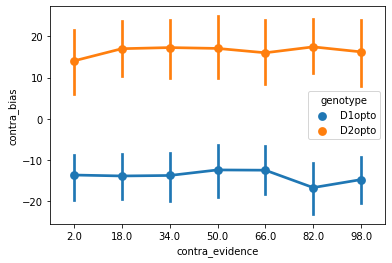

In [205]:
sns.pointplot(data=ro_expanded_df, x='contra_evidence', y='contra_bias', hue='genotype')
plt.show()

In [ ]:
# Stuff for psychometric fittings

In [ ]:
# def plot_hist_and_line(data_for_hist, line, ax):
#     ax.hist(data_for_hist, bins=100, color='c')
#     ax.axvline(x=line, color='m')
#     return ax

In [ ]:
# # Plot the distributions

# n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

# fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
#                         figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
#                         facecolor='w', edgecolor='k')

# fig.subplots_adjust(hspace = .2, wspace=1)

# for ax in axs.ravel(): ax.axis('off')

# for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
#     animal_df = pulledData[pulledData['AnimalID'] == animal]
    
#     for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
#         session_df = pulledData[pulledData['SessionID'] == session]
        
#         ax = axs[an_counter, counter]        

#         session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
# #         opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
# #         trialsDif = np.array(opto_df['TrialHighPerc'])
# #         sideSelected = np.array(opto_df['FirstPoke'])
# #         difficulty, performance = cuf.get_choices(sideSelected, trialsDif)

# #         s, b, u, l = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance)
# #         ups = cuf.sigmoid_func(50, s, b, u, l)
#         ups = 0
#         plot_hist_and_line(random_opto_df.loc[session_idx].sf_updown_shift, ups, ax=ax)
        
#         #axs[counter].set_ylabel('')
#         #axs[counter].set_xlabel('')
#         ax.axis('on')
#         # remove some ticks
#         ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
#                        labelleft='on', labelbottom='on')
#         if not ax.is_first_col():
#             ax.set_ylabel('')
#             ax.set_yticks([])
#         if not ax.is_last_row():
#             ax.set_xlabel('')
#             ax.set_xticks([])
                   
# #         ax.set_ylim(-2., 102.)
#         #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
#         ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
#                        labelleft='on', labelbottom='on')
        
        
#         # calculate pval
#         pval = np.sum(random_opto_df.loc[session_idx].sf_updown_shift > ups) / len(random_opto_df.loc[session_idx].sf_updown_shift)
#         if pval > .5: pval = 1 - pval
        
        
#         # get rid of the frame if not significant
#         if pval > .05:
#             for spine in ax.spines.values():
#                 spine.set_visible(False)
        
#         plt.tight_layout()
        
#         ax.invert_xaxis()
        
# #         ax.get_legend().remove()
#         ax.text(.5,1.05, str(counter) + ': ' + (session), \
#                           horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

#         ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
#                           horizontalalignment='center', transform=ax.transAxes)
#         ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
#                           horizontalalignment='center', transform=ax.transAxes)
#         ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
#                           horizontalalignment='center', transform=ax.transAxes)
#         ax.text(.5,.85, 'pval = ' + "{:.3f}".format(pval), horizontalalignment='center', transform=ax.transAxes)


#     update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
# update_progress(1)
# plt.savefig(outputDir + output_directory_name + '_significance_shifts.pdf', transparent=True, bbox_inches='tight')

# plt.show(fig)

#### Group sessions together

In [ ]:
# # make a plot for every mouse in with the slopes and shifts are plotted for every session
# stim_types = ['Both', 'Right', 'Left']
# colors = ['k', 'c', 'm']


# fig, axs = plt.subplots(math.ceil(len(pd.unique(random_opto_df.AnimalID))/3), 3,
#                         figsize=(15, 5 * len(pd.unique(random_opto_df.AnimalID))/3),
#                         facecolor='w', edgecolor='k', sharex=False, sharey=False)
# axs = axs.ravel()

# for ac, animal in enumerate(pd.unique(random_opto_df.AnimalID)):
#     ax = axs[ac]
#     ax.axvline(0, color='grey', linestyle='--')
#     ax.axhline(0, color='grey', linestyle='--')
#     ax.set_title(animal)
    
#     animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]

#     for session in pd.unique(animal_rdf.SessionID):
#         session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
#         sl_d = animal_rdf.loc[session_idx].slopes_mean_dif
#         sh_d = animal_rdf.loc[session_idx].shift_mean_dif
#         sl_std = animal_rdf.loc[session_idx].slopes_std
#         sh_std = animal_rdf.loc[session_idx].shift_std
#         st_t = animal_rdf.loc[session_idx].Stimulation
#         st_idx = stim_types.index(st_t)
        
#         ax.plot(sl_d, sh_d, 'o', ms=8,color=colors[st_idx])
#         ax.plot([sl_d, sl_d], [sh_d-sh_std, sh_d+sh_std], color=colors[st_idx])
#         ax.plot([sl_d-sl_std, sl_d+sl_std], [sh_d, sh_d], color=colors[st_idx])

#     update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

# plt.savefig(outputDir + output_directory_name + '_significance_slope-and-shift_grouped-per-animal.pdf', transparent=True, bbox_inches='tight')

# plt.show(fig)

In [ ]:
# OLD STUFF FOR THE FUCKED UP DATASET

In [ ]:
# remove the error bars as it is too much. Maybe?
# Try colouring the dots if they are significant
# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
# Take the first two distinct tests in each direction for the grouping, and plot first left and then right
# add jitter and connect the sessions for the same mouse
jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (5 * len(mice_cohorts), 5), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(mice_cohorts[i])
#     ax.tick_params(which='both', top='off', bottom='off', left='on', right='off',
#                        labelleft='on', labelbottom='on')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(stim_types)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)

# set label for y axis
axs[0].set_ylabel('Left shift')

#for sending data to Joaquin
sess_list = []

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.zeros(len(stim_types))
    animal_xs = np.zeros(len(stim_types))
    animal_flag = np.zeros(len(stim_types))
    for session in pd.unique(animal_rdf.SessionID):
        # if there are enough number of trials:
        if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
            session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
            cohort = animal_rdf.loc[session_idx].Genotype
            st_t = animal_rdf.loc[session_idx].Stimulation
            ax = axs[mice_cohorts.index(cohort)]
            if st_t in stim_types:
                st_t_idx = stim_types.index(st_t)
                if stim_flags[st_t_idx] == 0:
                    sess_list.append(session)
                    stim_flags[st_t_idx] = 1
                    o_s = animal_rdf.loc[session_idx].opto_shift
                    sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                    sh_std = animal_rdf.loc[session_idx].shift_std
                    sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                    sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                    imp_jit = random.uniform(-jitter, jitter)
                    x_pos = st_t_idx + imp_jit
                    animal_xs[st_t_idx] = x_pos
                    animal_ys[st_t_idx] = sh_d
                    animal_flag[st_t_idx] = 1

                    # check if significant
                    is_sig = (sh_lper * sh_hper) > 0

                    #means
                    if is_sig:
                        ax.plot(x_pos, sh_d, 'o', ms=14, color=colors[st_t_idx], alpha=alpha)
                    else:
                        ax.plot(x_pos, sh_d, 'o', ms=14, color=colors[st_t_idx], alpha=alpha, markerfacecolor='none')
            
    #connect
    if np.all(animal_flag == 1):
        ax.plot(animal_xs, animal_ys, color = 'grey', linewidth = 0.5, linestyle = '--')

    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped-coloured-by-significance.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Simplify even further, by just plotting the contralateral shift of the first stimulated session

# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)


jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, ax = plt.subplots(1, 1, figsize = (5, 5))


ax.axhline(0, color='grey', linestyle='--')
ax.set_title('Ipsilateral bias')

ax.set_xticks([0, 1])
ax.set_xticklabels(mice_cohorts)
# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

# set label for y axis
ax.set_ylabel('Ipsilateral shift')    

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flag for plotting only the first session (they are ordered)
    stim_flag = 0

    for session in pd.unique(animal_rdf.SessionID):
        # if there are enough number of trials:
        if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
            session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
            cohort = animal_rdf.loc[session_idx].Genotype
            st_t = animal_rdf.loc[session_idx].Stimulation
            x_idx = mice_cohorts.index(cohort)
            if st_t in stim_types:
                if stim_flag == 0:
                    stim_flag = 1

                    o_s = animal_rdf.loc[session_idx].opto_shift
                    sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                    # reverse if the stimulation is on the right
                    if st_t == 'Right':
                        sh_d = -sh_d
                    sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                    sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                    imp_jit = random.uniform(-jitter, jitter)
                    x_pos = x_idx + imp_jit

                    # check if significant
                    is_sig = (sh_lper * sh_hper) > 0

                    #means
                    if is_sig:
                        ax.plot(x_pos, sh_d, 'o', ms=14, color=colors[x_idx], alpha=alpha)
                    else:
                        ax.plot(x_pos, sh_d, 'o', ms=14, color=colors[x_idx], alpha=alpha, markerfacecolor='none')

plt.savefig(outputDir + output_directory_name + '_shift_grouped_ipsilateral-shift_first-session_coloured-by-significance.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Simplify even further, by just plotting the contralateral shift of the first stimulated session

# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)


jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, ax = plt.subplots(1, 1, figsize = (5, 5))


ax.axhline(0, color='grey', linestyle='--')
ax.set_title('Ipsilateral bias')

ax.set_xticks([0, 1])
ax.set_xticklabels(mice_cohorts)
# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

# set label for y axis
ax.set_ylabel('Ipsilateral shift')    

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.empty(len(stim_types))
    animal_ys[:] = np.NaN
    animal_flag = np.zeros(len(stim_types))

    for session in pd.unique(animal_rdf.SessionID):
        # if there are enough number of trials:
        if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
            session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
            cohort = animal_rdf.loc[session_idx].Genotype
            st_t = animal_rdf.loc[session_idx].Stimulation
            x_idx = mice_cohorts.index(cohort)
            if st_t in stim_types:
                st_t_idx = stim_types.index(st_t)
                if stim_flags[st_t_idx] == 0:
                    stim_flags[st_t_idx] = 1

                    o_s = animal_rdf.loc[session_idx].opto_shift
                    sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                    # reverse if the stimulation is on the right
                    if st_t == 'Right':
                        sh_d = -sh_d
                    sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                    sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                    # store to make the mean later
                    animal_ys[st_t_idx] = sh_d
                
    imp_jit = random.uniform(-jitter, jitter)
    x_pos = x_idx + imp_jit

    ax.plot(x_pos, np.nanmean(animal_ys), 'o', ms=14, color=colors[x_idx], alpha=alpha, markerfacecolor='none')


    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped_ipsilateral-shift_two-sessions-means.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:

# Now with the maximum value

# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)


jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, ax = plt.subplots(1, 1, figsize = (5, 5))


ax.axhline(0, color='grey', linestyle='--')
ax.set_title('Ipsilateral bias')

ax.set_xticks([0, 1])
ax.set_xticklabels(mice_cohorts)
# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

# set label for y axis
ax.set_ylabel('Ipsilateral shift')    

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.empty(len(stim_types))
    animal_ys[:] = np.NaN
    animal_flag = np.zeros(len(stim_types))

    for session in pd.unique(animal_rdf.SessionID):
        # if there are enough number of trials:
        if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
            session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
            cohort = animal_rdf.loc[session_idx].Genotype
            st_t = animal_rdf.loc[session_idx].Stimulation
            x_idx = mice_cohorts.index(cohort)
            if st_t in stim_types:
                st_t_idx = stim_types.index(st_t)
                if stim_flags[st_t_idx] == 0:
                    stim_flags[st_t_idx] = 1

                    o_s = animal_rdf.loc[session_idx].opto_shift
                    sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                    # reverse if the stimulation is on the right
                    if st_t == 'Right':
                        sh_d = -sh_d
                    sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                    sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                    # store to make the mean later
                    animal_ys[st_t_idx] = sh_d
                
    imp_jit = random.uniform(-jitter, jitter)
    x_pos = x_idx + imp_jit
    
    # check that that animal has no data
    if not np.all(np.isnan(animal_ys)):
        max_idx = np.nanargmax(np.abs(animal_ys))

        ax.plot(x_pos, animal_ys[max_idx], 'o', ms=14, color=colors[x_idx], alpha=alpha, markerfacecolor = 'None')


    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped_ipsilateral-shift_two-sessions-max.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Plot the z-score

# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
# Take the first two distinct tests in each direction for the grouping, and plot first left and then right
# add jitter and connect the sessions for the same mouse
jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (5 * len(mice_cohorts), 5), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(mice_cohorts[i])
#     ax.tick_params(which='both', top='off', bottom='off', left='on', right='off',
#                        labelleft='on', labelbottom='on')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(stim_types)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)

# set label for y axis
axs[0].set_ylabel('Left shift z-score')

#for sending data to Joaquin
sess_list = []

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.zeros(len(stim_types))
    animal_xs = np.zeros(len(stim_types))
    animal_flag = np.zeros(len(stim_types))
    for session in pd.unique(animal_rdf.SessionID):
        # if there are enough number of trials:
        if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
            session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
            cohort = animal_rdf.loc[session_idx].Genotype
            st_t = animal_rdf.loc[session_idx].Stimulation
            ax = axs[mice_cohorts.index(cohort)]
            if st_t in stim_types:
                st_t_idx = stim_types.index(st_t)
                if stim_flags[st_t_idx] == 0:
                    sess_list.append(session)
                    stim_flags[st_t_idx] = 1
                    o_s = animal_rdf.loc[session_idx].opto_shift
                    sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                    sh_std = animal_rdf.loc[session_idx].shift_std
                    sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                    sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                    z_score = sh_d / sh_std

                    imp_jit = random.uniform(-jitter, jitter)
                    x_pos = st_t_idx + imp_jit
                    animal_xs[st_t_idx] = x_pos
                    animal_ys[st_t_idx] = z_score
                    animal_flag[st_t_idx] = 1

                    # check if significant
                    is_sig = (sh_lper * sh_hper) > 0

                    #means
                    if is_sig:
                        ax.plot(x_pos, z_score, 'o', ms=14, color=colors[st_t_idx], alpha=alpha)
                    else:
                        ax.plot(x_pos, z_score, 'o', ms=14, color=colors[st_t_idx], alpha=alpha, markerfacecolor='none')
            
    #connect
    if np.all(animal_flag == 1):
        ax.plot(animal_xs, animal_ys, color = 'grey', linewidth = 0.5, linestyle = '--')

    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped-coloured-by-significance_z-score.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# test removing those sessions in which the light intensity was very high
sess_list

In [ ]:
sessions_to_remove = ['D1opto-05 Nov01 13:29',
                      'D2opto-06 Nov01 15:36',
                      'D2opto-03 Nov01 14:27',
                      'D2opto-04 Oct28 15:36']

In [ ]:
# Plot the z-score

# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
# Take the first two distinct tests in each direction for the grouping, and plot first left and then right
# add jitter and connect the sessions for the same mouse
jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, axs = plt.subplots(1, len(mice_cohorts), figsize = (5 * len(mice_cohorts), 5), sharey=True)

axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.axhline(0, color='grey', linestyle='--')
    ax.set_title(mice_cohorts[i])
#     ax.tick_params(which='both', top='off', bottom='off', left='on', right='off',
#                        labelleft='on', labelbottom='on')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(stim_types)
    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)

# set label for y axis
axs[0].set_ylabel('Left shift z-score')

#for sending data to Joaquin
sess_list = []

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.zeros(len(stim_types))
    animal_xs = np.zeros(len(stim_types))
    animal_flag = np.zeros(len(stim_types))
    for session in pd.unique(animal_rdf.SessionID):
        # if that session is not in the list
        if session not in sessions_to_remove:
            # if there are enough number of trials:
            if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
                session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
                cohort = animal_rdf.loc[session_idx].Genotype
                st_t = animal_rdf.loc[session_idx].Stimulation
                ax = axs[mice_cohorts.index(cohort)]
                if st_t in stim_types:
                    st_t_idx = stim_types.index(st_t)
                    if stim_flags[st_t_idx] == 0:
                        sess_list.append(session)
                        stim_flags[st_t_idx] = 1
                        o_s = animal_rdf.loc[session_idx].opto_shift
                        sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                        sh_std = animal_rdf.loc[session_idx].shift_std
                        sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                        sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                        z_score = sh_d / sh_std

                        imp_jit = random.uniform(-jitter, jitter)
                        x_pos = st_t_idx + imp_jit
                        animal_xs[st_t_idx] = x_pos
                        animal_ys[st_t_idx] = z_score
                        animal_flag[st_t_idx] = 1

                        # check if significant
                        is_sig = (sh_lper * sh_hper) > 0

                        #means
                        if is_sig:
                            ax.plot(x_pos, z_score, 'o', ms=14, color=colors[st_t_idx], alpha=alpha)
                        else:
                            ax.plot(x_pos, z_score, 'o', ms=14, color=colors[st_t_idx], alpha=alpha, markerfacecolor='none')

    #connect
    if np.all(animal_flag == 1):
        ax.plot(animal_xs, animal_ys, color = 'grey', linewidth = 0.5, linestyle = '--')

    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped-coloured-by-significance_z-score_low-light-intensity-sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Simplify even further, by just plotting the contralateral shift of the first stimulated session

# Remove the JAWS mice and flat fibers
mice_to_remove = ['D1opto-08', 'D1opto-09']
#                   'D1opto-06', 'D1opto-07', 'D2opto-03', 'D2opto-04']
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)


jitter = 0.1
alpha = 0.5

stim_types = ['Left', 'Right']
mice_cohorts = ['D1opto', 'D2opto'] 
colors = ['k', 'k']

fig, ax = plt.subplots(1, 1, figsize = (5, 5))


ax.axhline(0, color='grey', linestyle='--')
ax.set_title('Ipsilateral bias')

ax.set_xticks([0, 1])
ax.set_xticklabels(mice_cohorts)
# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

# set label for y axis
ax.set_ylabel('Ipsilateral shift')    

for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    # flags for plotting only the first session (they are ordered)
    stim_flags = np.zeros(len(stim_types))
    # create an array to store connecting dots
    animal_ys = np.empty(len(stim_types))
    animal_ys[:] = np.NaN
    animal_flag = np.zeros(len(stim_types))

    for session in pd.unique(animal_rdf.SessionID):
        # if that session is not in the list
        if session not in sessions_to_remove:
            # if there are enough number of trials:
            if len(pulledData[(pulledData['SessionID'] == session)]) >= MIN_TRIALS:
                session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
                cohort = animal_rdf.loc[session_idx].Genotype
                st_t = animal_rdf.loc[session_idx].Stimulation
                x_idx = mice_cohorts.index(cohort)
                if st_t in stim_types:
                    st_t_idx = stim_types.index(st_t)
                    if stim_flags[st_t_idx] == 0:
                        stim_flags[st_t_idx] = 1

                        o_s = animal_rdf.loc[session_idx].opto_shift
                        sh_d = animal_rdf.loc[session_idx].shift_mean - o_s
                        # reverse if the stimulation is on the right
                        if st_t == 'Right':
                            sh_d = -sh_d
                        sh_lper = animal_rdf.loc[session_idx].shift_low_per - o_s
                        sh_hper = animal_rdf.loc[session_idx].shift_high_per - o_s

                        # store to make the mean later
                        animal_ys[st_t_idx] = sh_d
                
    imp_jit = random.uniform(-jitter, jitter)
    x_pos = x_idx + imp_jit

    ax.plot(x_pos, np.nanmean(animal_ys), 'o', ms=14, color=colors[x_idx], alpha=alpha, markerfacecolor='none')


    #update_progress((ac + 1) / len(pd.unique(random_opto_df.AnimalID)))

plt.savefig(outputDir + output_directory_name + '_shift_grouped_ipsilateral-shift_two-sessions-means_low-light-intensity-sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Test the effects on the subsequent trial

In [ ]:
# Add to the dataframe if the previous trial had opto

In [ ]:
pulledData['PreviousOpto'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            opto_prev = pulledData.loc[idx_prev].OptoStim
        else:
            opto_prev = np.nan

        pulledData.at[idx, 'PreviousOpto'] = opto_prev

In [ ]:
pulledData

In [ ]:
# generate a list of the conditions, colors and labels
CondList = [test_df['PreviousOpto'] == 0, test_df['PreviousOpto'] == 1]
ColorList = ['k', 'c']
LabelList = ['Previous normal', 'Previous opto']
# plot
fig, axs = plt.subplots(1,1,figsize=(7, 7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3)
axs.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, _ =\
    cuf.PP_ProcessExperiment(test_df[condition], 5)#, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i])#, errorBars = EB)
lgd = plt.legend()
# plt.suptitle(AnimalID + '_' + PlotsTitle)
plt.show(fig)

In [ ]:
CondList = [(pulledData['PreviousOpto']==0),
            (pulledData['PreviousOpto']==1)]
ColorList = ['c', 'm']
LabelList = ['Previous Normal', 'Previous Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)
        
        for i, condition in enumerate(CondList):
            predictDif, PsyPer, fakePredictions, predictPer, _ =\
            cuf.PP_ProcessExperiment(session_df[condition], 15)#, error_bars='SessionTime')
            if PsyPer:
                plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                             predictDif = predictDif, ax = ax, fakePred = fakePredictions,
                             realPred = predictPer, color = ColorList[i], label = LabelList[i])#, errorBars = EB)
        
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_effect_of_previous_opto.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

#### Deprecated

#### For grouping sessions differently, normalize to the opto trials
###### Assess significance by normalizing to random picks, from the random opto dataset

In [ ]:
# Normalized:
n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        ax = axs[an_counter, counter]
        
        ax.hlines(0, 0, 100, linestyles='dotted', alpha=0.4)
        
        plot_utils.plot_random_optolike_choices(df=animal_df[(animal_df['SessionID'] == session)],
                                                ax=ax,
                                                fake_dataset_m_and_std=fd_m_and_std,
                                                normalize=True)

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
#         ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_normalized.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Normalized and grouped:
n_cols = 3

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(20, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for session in pd.unique(animal_df['SessionID']):
        session_df = animal_df[animal_df['SessionID'] == session]
        opto_side = session_df.iloc[0]['Stimulation']
        if opto_side == 'Both':
            ax = axs[an_counter, 0]
        elif opto_side == 'Right':
            ax = axs[an_counter, 1]
        elif opto_side == 'Left':
            ax = axs[an_counter, 2]
        else:
            sys.exit('Issue with opto text')
        True
        ax.hlines(0, 0, 100, linestyles='dotted', alpha=0.4)
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=fd_m_and_std,
                                                normalize=True,
                                                jitter=4)

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
#         ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_normalized_grouped.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Fit and quantify

In [ ]:
# Plot with scikit-learn (does not work very well)

CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=.2)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        ax = axs[an_counter, counter]
        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)
        
        for i, condition in enumerate(CondList):
            predictDif, PsyPer, fakePredictions, predictPer, _ = \
            cuf.PP_ProcessExperiment(animal_df[(animal_df['SessionID'] == session) & condition], bootstrap=5)
            if PsyPer:
                plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                                predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                                realPred =predictPer, color=ColorList[i], label=LabelList[i])

        ax.get_legend().remove()
        ax.text(.5,.95, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,.85, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.75, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.65, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
        plt.tight_layout()

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_scikit-learn_fits_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max() + 1

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(25, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        ax = axs[an_counter, counter]
        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)
        
        for i, condition in enumerate(CondList):
            
            plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
                                       color = ColorList[i], label = LabelList[i])

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
        ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_custom_fits_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
session = 'D1opto-01 Jul29 09:29'
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax=ax.ravel()
session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
trialsDif = np.array(opto_df['TrialHighPerc'])
sideSelected = np.array(opto_df['FirstPoke'])
difficulty, performance = cuf.get_choices(sideSelected, trialsDif)

s, b, u, l = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=performance)
ups = cuf.sigmoid_func(50, s, b, u, l)

plot_hist_and_line(random_opto_df.loc[session_idx].sf_slopes, s, ax=ax[0])
ax[0].set_title(np.sum(random_opto_df.loc[session_idx].sf_slopes > s) / len(random_opto_df.loc[session_idx].sf_slopes))
plot_hist_and_line(random_opto_df.loc[session_idx].sf_updown_shift, ups, ax=ax[1])
ax[1].set_title(np.sum(random_opto_df.loc[session_idx].sf_updown_shift > ups) / len(random_opto_df.loc[session_idx].sf_intercepts))


session_df = pulledData[pulledData['SessionID'] == session]
avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()

plot_utils.plot_random_optolike_choices(df=session_df,
                                        ax=ax[2],
                                        fake_dataset_m_and_std=[avail_diffs,
                                                                np.mean(rand_choices_ds, axis=0),
                                                                np.std(rand_choices_ds, axis=0)])
# overlay fits
CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']
for i, condition in enumerate(CondList):
    plot_utils.plot_regression(df=pulledData[(pulledData['SessionID'] == session) & condition], ax=ax[2],
                               color=ColorList[i], label=LabelList[i], plot_points=False)

ax[2].invert_xaxis()

In [ ]:
# This is weird, see session 'D2opto-03 Oct29 15:56'
# plot one of the session with higher intercept
r_s = random.choice(np.where(random_opto_df.loc[session_idx].sf_updown_shift > ups)[0])
s_r, b_r, u_r, l_r = cuf.fit_custom_sigmoid(difficulty=difficulty, performance=rand_choices_ds[r_s])
x = np.linspace(0, 100)

ups_r = cuf.sigmoid_func(50,s_r, b_r, u_r, l_r)

fig, ax = plt.subplots(1,1)
ax.plot(difficulty, performance, 'o', color='m')
ax.plot(difficulty, rand_choices_ds[r_s], 'o', color='c')
sns.lineplot(x=x,
             y=cuf.sigmoid_func(x, *[s, b, u, l]),
             color='m',
             ci=None,
             ax=ax)
sns.lineplot(x=x,
             y=cuf.sigmoid_func(x, *[s_r, b_r, u_r, l_r]),
             color='c',
             ci=None,
             ax=ax)
ax.invert_xaxis()
ax.set_title('opto: {}; random: {}'.format(ups, ups_r))
plt.show()